In [34]:
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

from models import *
from datasets import *
from utils import *

import torch.nn as nn
import torch.nn.functional as F
import torch

from dataset.time_dataset import TsNewTestDataset
from pathlib import Path

import matplotlib.pyplot as plt

In [35]:
noise_type='other'

In [36]:
# Dataset
datapath = Path('data')
dataset = TsNewTestDataset(datapath/'Book31.csv', noise_type='none', normalize=False)

data_all = dataset.data_all

data_normal_noRE = dataset.data_normal
data_attacked_noRE = dataset.data_attacked

data_normal_RE = dataset.data_normal_RE
data_attacked_RE = dataset.data_attacked_RE
data_all.size(), data_normal_RE.size(), data_normal_noRE.size(), data_attacked_RE.size(), data_attacked_noRE.size()

(torch.Size([1, 379, 33]),
 torch.Size([1, 60, 33]),
 torch.Size([1, 45, 33]),
 torch.Size([1, 120, 33]),
 torch.Size([1, 154, 33]))

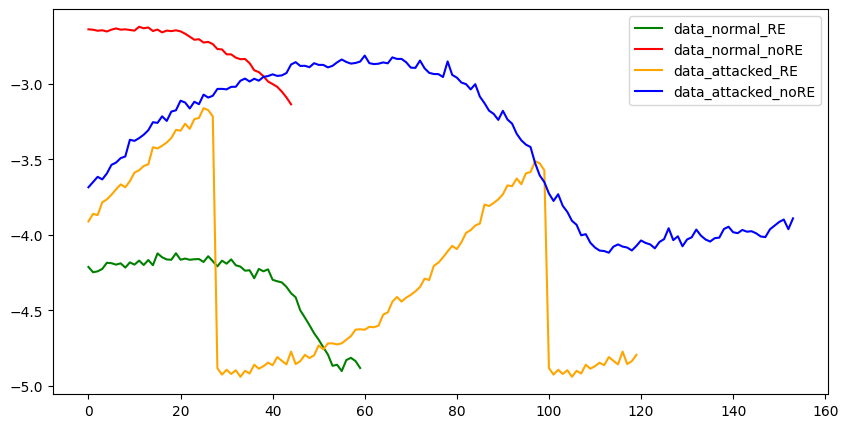

In [37]:
plt.figure(figsize=(10, 5))
# plt.plot(data_all[0, :, 0])
plt.plot(data_normal_RE[0, :, 0], color='green')
plt.plot(data_normal_noRE[0, :, 0], color='red')
plt.plot(data_attacked_RE[0, :, 0], color='orange')
plt.plot(data_attacked_noRE[0, :, 0], color='blue')
plt.legend(['data_normal_RE', 'data_normal_noRE', 'data_attacked_RE', 'data_attacked_noRE'])
plt.show()

In [38]:
dataset = TsNewTestDataset(datapath/'Book31.csv', noise_type='none')

data_all = dataset.data_all

data_normal_noRE = dataset.data_normal
data_attacked_noRE = dataset.data_attacked

data_normal_RE = dataset.data_normal_RE
data_attacked_RE = dataset.data_attacked_RE
data_all.size(), data_normal_RE.size(), data_normal_noRE.size(), data_attacked_RE.size(), data_attacked_noRE.size()

(torch.Size([1, 379, 33]),
 torch.Size([1, 60, 33]),
 torch.Size([1, 45, 33]),
 torch.Size([1, 120, 33]),
 torch.Size([1, 154, 33]))

In [39]:
normal_seq_len = data_normal_noRE.size(1)
normal_feature_len = data_normal_noRE.size(2)
attacked_seq_len = data_attacked_noRE.size(1)
attacked_feature_len = data_attacked_noRE.size(2)

G_AB = LSTMFullGenerator(normal_seq_len, normal_feature_len)
G_BA = LSTMFullGenerator(attacked_seq_len, attacked_feature_len)
D_A = LSTMFullDiscriminator(normal_feature_len)
D_B = LSTMFullDiscriminator(normal_feature_len)

G_AB.load_state_dict(torch.load(f"saved_models/true/{noise_type}/G_AB_190.pth"))
G_BA.load_state_dict(torch.load(f"saved_models/true/{noise_type}/G_BA_190.pth"))
D_A.load_state_dict(torch.load(f"saved_models/true/{noise_type}/D_A_190.pth"))
D_B.load_state_dict(torch.load(f"saved_models/true/{noise_type}/D_B_190.pth"))

G_AB.eval()
G_BA.eval()
D_A.eval()
D_B.eval()

LSTMFullDiscriminator(
  (lstm): LSTM(33, 256, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=256, out_features=33, bias=True)
    (1): Sigmoid()
  )
)

In [40]:
data_all.size()

torch.Size([1, 379, 33])

In [41]:
data_new = data_all[:,:360,:].reshape(-1, 30, data_all.size(2))
data_new.shape

torch.Size([12, 30, 33])

In [42]:
with torch.no_grad():
    output = G_AB(data_new)
    output_back = G_BA(output)
    print(f"Output size: {output.size()} \t Output Back size: {output_back.size()}")

Output size: torch.Size([12, 30, 33]) 	 Output Back size: torch.Size([12, 30, 33])


In [43]:
os.makedirs(f'cyber_result/true_newest/{noise_type}', exist_ok=True)
Res_list = []

for i in range(output.size(0)):
    os.makedirs(f'cyber_result/true_newest/{noise_type}/Seg{i}', exist_ok=True)
    for feature_number in range(output.size(2)):
        plt.plot(output[i, :, feature_number].numpy())
        plt.plot(output_back[i, :, feature_number].numpy())
        plt.plot(data_new[i, :, feature_number].numpy())
        plt.legend(['Generated', 'Generated Back', 'Origina Data'])
        plt.savefig(f'cyber_result/true_newest/{noise_type}/Seg{i}/output_{i}_feature{feature_number}.png')
        plt.close()
    dist1 = torch.mean(np.abs(data_new[i] - output[i]))
    dist2 = torch.mean(np.abs(output[i] - output_back[i]))
    dist3 = torch.mean(np.abs(output_back[i] - data_new[i]))
    res = (dist2+dist3)/dist1
    Res_list.append(res)
    print(i, res, dist1, dist2, dist3)

0 tensor(1.3132) tensor(0.2690) tensor(0.1621) tensor(0.1912)
1 tensor(1.2966) tensor(0.2774) tensor(0.1617) tensor(0.1980)
2 tensor(1.3882) tensor(0.2348) tensor(0.1632) tensor(0.1628)
3 tensor(1.3287) tensor(0.2535) tensor(0.1631) tensor(0.1737)
4 tensor(1.3103) tensor(0.2714) tensor(0.1612) tensor(0.1944)
5 tensor(1.3064) tensor(0.2756) tensor(0.1622) tensor(0.1978)
6 tensor(1.3352) tensor(0.2616) tensor(0.1621) tensor(0.1872)
7 tensor(1.2631) tensor(0.2714) tensor(0.1608) tensor(0.1819)
8 tensor(1.3184) tensor(0.2432) tensor(0.1632) tensor(0.1574)
9 tensor(1.3516) tensor(0.2376) tensor(0.1632) tensor(0.1579)
10 tensor(1.2659) tensor(0.2495) tensor(0.1628) tensor(0.1531)
11 tensor(1.1993) tensor(0.2706) tensor(0.1638) tensor(0.1607)


In [44]:
plt.figure(figsize=(10, 5))
plt.plot(range(len(Res_list)), Res_list)
plt.savefig(f'cyber_result/true_newest/{noise_type}/Res.png')
plt.close()
print(f"Mean Res: {np.mean(Res_list)}")
print(f"Max Res: {np.max(Res_list)}")

Mean Res: 1.3064048290252686
Max Res: 1.388200283050537
